In [18]:
# pip install --upgrade pip
# pip install torch
# pip install torchvision
# pip install pycocotools
# pip faiss-cpu


In [19]:
import torch
import torchvision
from torchvision import transforms, datasets
from IPython.display import Image

In [20]:
print(torch.__version__)
print(torchvision.__version__)
print(torchvision.datasets)

2.1.1+cpu
0.16.1+cpu
<module 'torchvision.datasets' from 'c:\\Users\\sobata\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\torchvision\\datasets\\__init__.py'>


In [21]:
base_folder = '../data/'
image_folder = base_folder + "val2014/val2014/"
ann_file = base_folder + "annotations/captions_val2014.json"

transform = transforms.Compose([transforms.ToTensor()])
val_dataset = torchvision.datasets.CocoDetection(
    root=image_folder,
    annFile=ann_file,
    transform=transform
)

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


In [22]:
# _, label = val_dataset[1]
# for l in label:
#     print(l)
# image_file_name = "COCO_val2014_" + str(label[0]["image_id"]).zfill(12) + ".jpg"
# Image(image_folder + image_file_name)

In [23]:
import os
from dotenv import load_dotenv

load_dotenv()

VISION_ENDPOINT = os.getenv('VISION_ENDPOINT')
VISION_API_KEY = os.getenv('VISION_API_KEY')

In [24]:
import json
import requests
import faiss
import numpy as np

images = []
labels = []
vectors = []
num = 2  # 今回はデータセットのうち画像1,000枚をベクトル化
for i in range(num):
    _, label = val_dataset[i]
    labels.append(label)
    image_file_name = "COCO_val2014_" + str(label[0]["image_id"]).zfill(12) + ".jpg"
    images.append(image_folder + image_file_name)  # 画像ファイルのパス

endpoint = os.getenv("VISION_ENDPOINT") + "/computervision/retrieval:vectorizeImage?api-version=2023-02-01-preview&modelVersion=latest"
headers = {
    "Content-Type": "application/octet-stream",  # リクエストボディは画像のバイナリデータ
    "Ocp-Apim-Subscription-Key": os.getenv("VISION_API_KEY")
}

for idx, image in enumerate(images):
    with open(image, mode="rb") as f:
        image_bin = f.read()
    # Vectorize Image API を使って画像をベクトル化
    response = requests.post(endpoint, headers=headers, data=image_bin)
    # print(response.json())
    image_vec = np.array(response.json()["vector"], dtype="float32").reshape(1, -1)
    vectors.append(image_vec)

In [25]:
print(vectors)

[array([[ 1.6416016 , -3.5449219 , -1.6220703 , ...,  0.86035156,
         0.11499023,  1.0517578 ]], dtype=float32), array([[-4.2890625, -1.9609375, -2.4140625, ...,  2.6738281, -2.2148438,
        -1.4960938]], dtype=float32)]


In [26]:
# import pickle

# with open("images.pkl", "wb") as f:
#     pickle.dump(images, f)

# with open("labels.pkl", "wb") as f:
#     pickle.dump(labels, f)

# with open("vectors.pkl", "wb") as f:
#     pickle.dump(vectors, f)

In [27]:
dimension = 1024
index_flat_l2 = faiss.IndexFlatL2(dimension)

In [28]:
for vector in vectors:
    index_flat_l2.add(vector)

In [29]:
print(index_flat_l2.ntotal)

2


In [30]:
def search_faiss_by_text(query_text, n=3):
    endpoint = os.getenv("VISION_ENDPOINT") + "/computervision/retrieval:vectorizeText?api-version=2023-02-01-preview&modelVersion=latest"
    headers = {
        "Content-Type": "application/json",
        "Ocp-Apim-Subscription-Key": os.getenv("VISION_API_KEY")
    }
    data = {
        "text": query_text
    }
    # Vectorize Text API を使ってクエリをベクトル化
    response = requests.post(endpoint, headers=headers, data=json.dumps(data))
    query_vector = np.array(response.json()["vector"], dtype="float32").reshape(1, -1)
    # Faiss 検索
    D, I = index_flat_l2.search(query_vector, n)
    return D, I

In [31]:
n = 6
D, I = search_faiss_by_text("dog", n)
print(D)
print(I)

[[8.4480156e+03 8.4529746e+03 3.4028235e+38 3.4028235e+38 3.4028235e+38
  3.4028235e+38]]
[[ 0  1 -1 -1 -1 -1]]


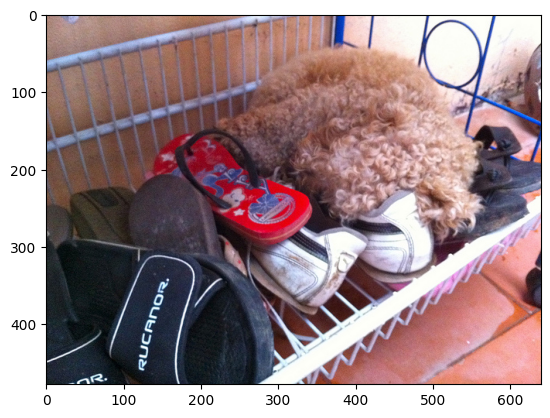

In [35]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
img = mpimg.imread(images[I[0][0]])
imgplot = plt.imshow(img)

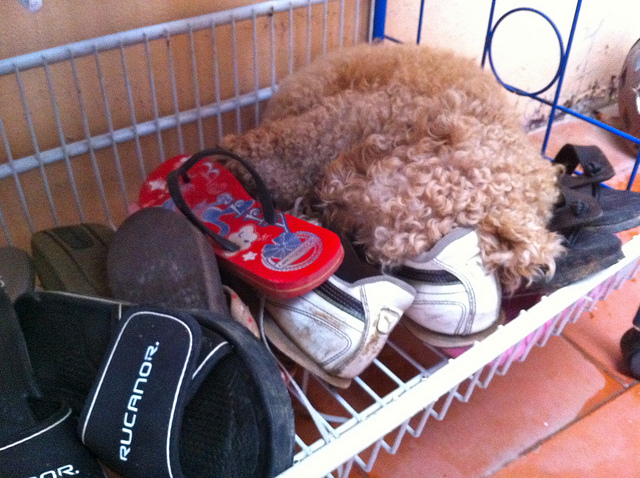

In [32]:
Image(images[I[0][0]])


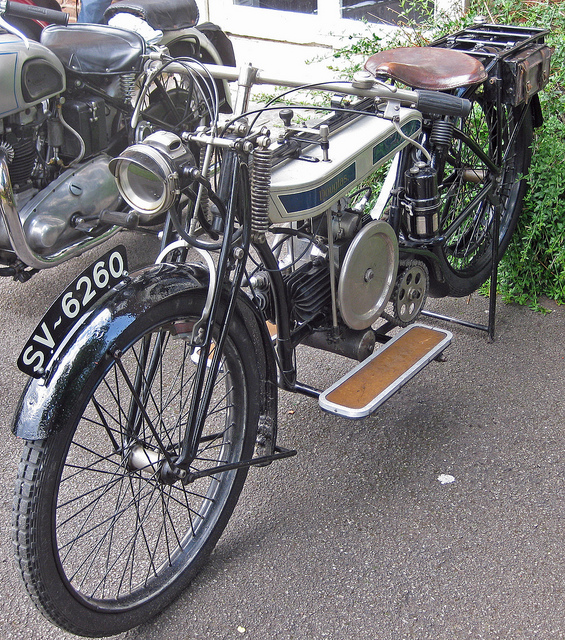

In [33]:
Image(images[I[0][1]])

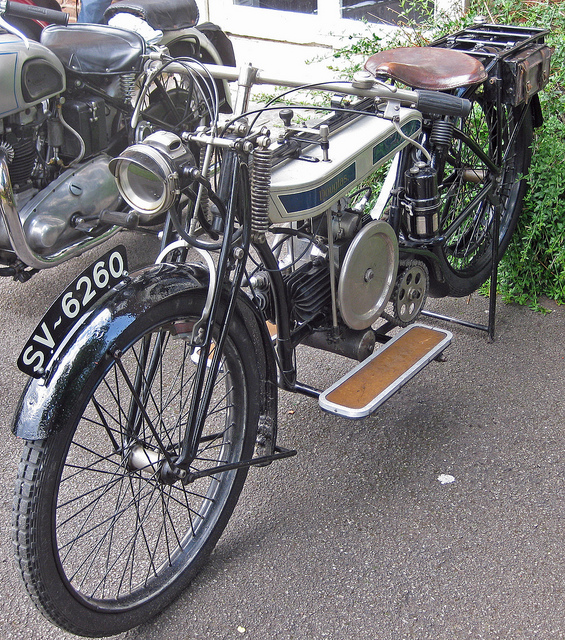

In [34]:
Image(images[I[0][2]])